Loading and Merging

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


Loading preprocessed data:

In [4]:
# loading X_train, X_test, y_train, y_test
X = pd.read_csv('data/X.csv')
y = pd.read_csv('data/y.csv')

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76822 entries, 0 to 76821
Columns: 495 entries, age to job_end_2019
dtypes: bool(259), float64(236)
memory usage: 157.3 MB



EDA label variable

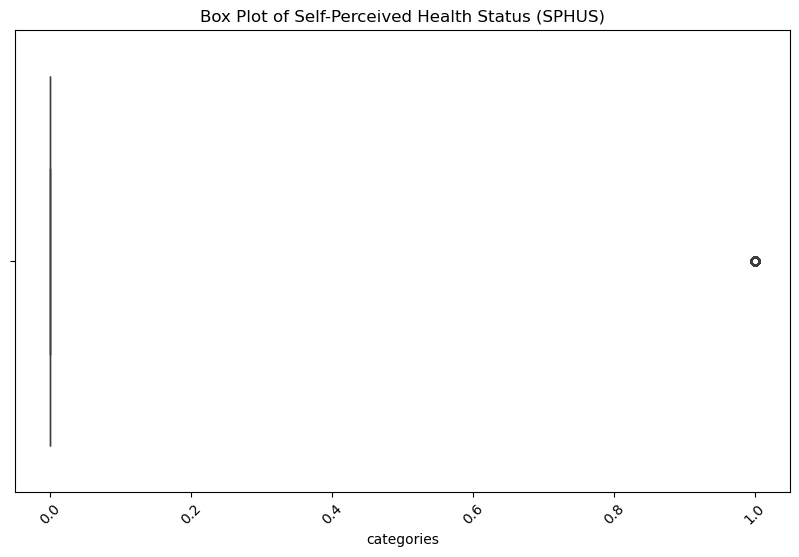

In [6]:
# box plot - doesn't make sense to do boxplot??
plt.figure(figsize=(10, 6))
sns.boxplot(x=y['sphus'])
plt.title('Box Plot of Self-Perceived Health Status (SPHUS)')
plt.xlabel('categories')
plt.xticks(rotation=45)
plt.show()

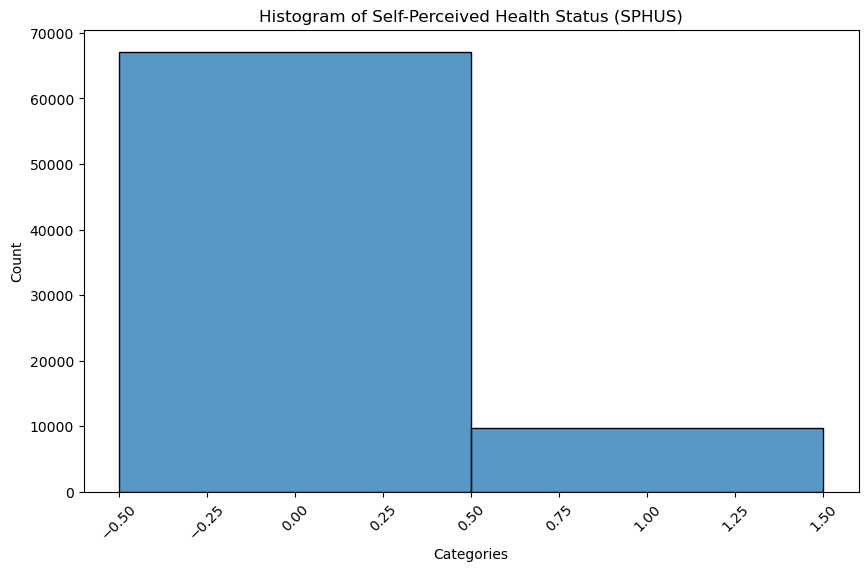

In [9]:
# histo
plt.figure(figsize=(10, 6))
sns.histplot(y['sphus'], discrete=True)
plt.title('Histogram of Self-Perceived Health Status (SPHUS)')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.show()

Grouped Feature Selection

In [7]:
variable_names = X.columns.tolist()

# Initialize lists for each category
temperature_vars = []
radiation_vars = []
precipitation_vars = []
pollution_vars = {'PM2.5': [], 'PM10': [], 'NO2': [], 'O3': []}
flood_vars = []
heating_cooling_vars = []  # For Heating Degree Days (HDD) and Cooling Degree Days (CDD)

for var in variable_names:
    # Temperature variables
    if 'tn_' in var or 'tg_' in var or 'tx_' in var:
        temperature_vars.append(var)
    
    # Radiation variables
    elif 'radiation' in var:
        radiation_vars.append(var)
    
    # Precipitation variables
    elif 'prec' in var:
        precipitation_vars.append(var)
    
    # Pollution variables
    elif 'pm2p5' in var or 'conc_pm2p5' in var:
        pollution_vars['PM2.5'].append(var)
    elif 'pm10' in var or 'conc_pm10' in var:
        pollution_vars['PM10'].append(var)
    elif 'no2' in var or 'conc_no2' in var:
        pollution_vars['NO2'].append(var)
    elif 'o3' in var or 'conc_o3' in var:
        pollution_vars['O3'].append(var)
    
    # Flood variables
    elif 'fl_' in var:
        flood_vars.append(var)
    
    # Heating and Cooling Degree Days
    elif 'HDD' in var or 'CDD' in var:
        heating_cooling_vars.append(var)

In [8]:
feature_groups = {
    'temperature': temperature_vars,
    'radiation': radiation_vars,
    'precipitation': precipitation_vars,
    'pollution_PM2.5': pollution_vars['PM2.5'],
    'pollution_PM10': pollution_vars['PM10'],
    'pollution_NO2': pollution_vars['NO2'],
    'pollution_O3': pollution_vars['O3'],
    'floods': flood_vars,
    'heating_cooling': heating_cooling_vars
}

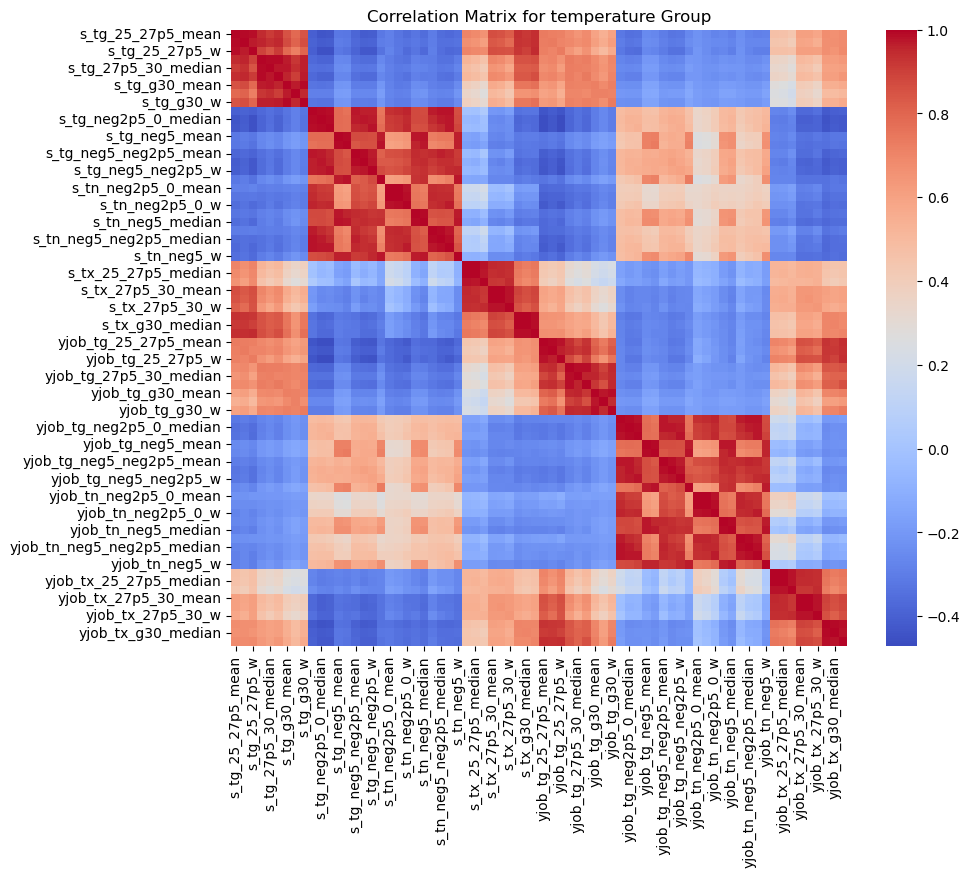

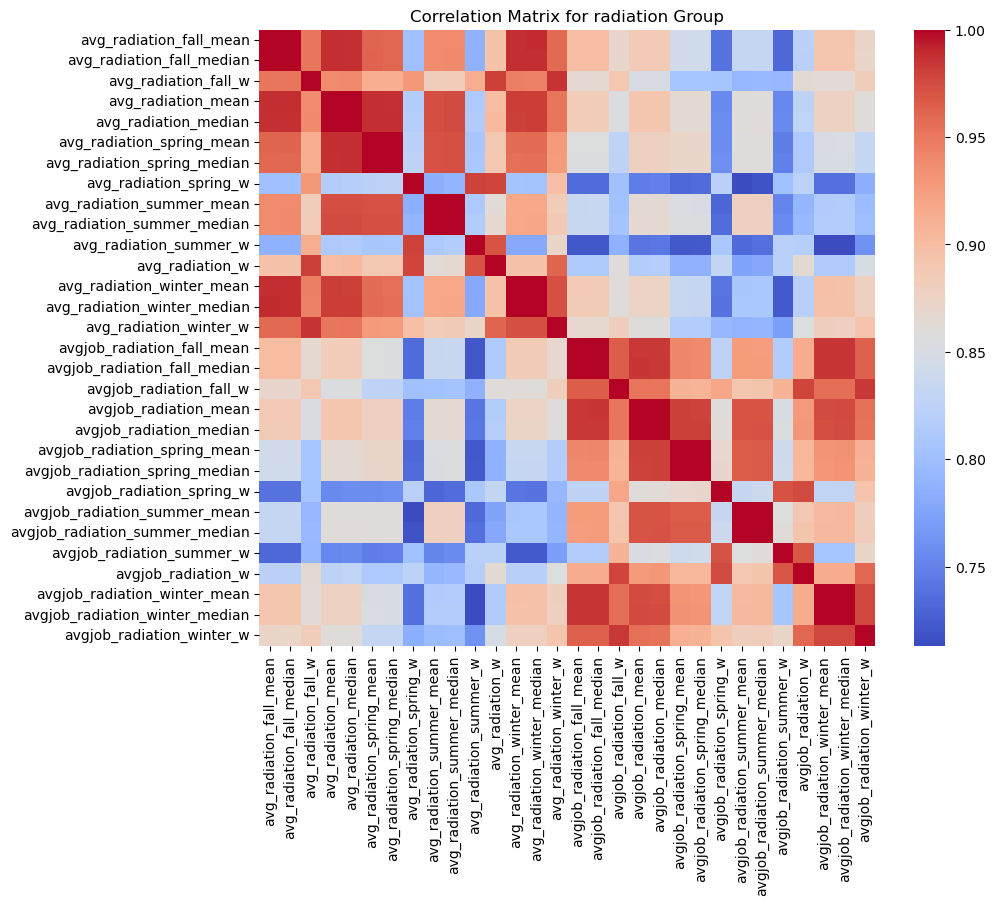

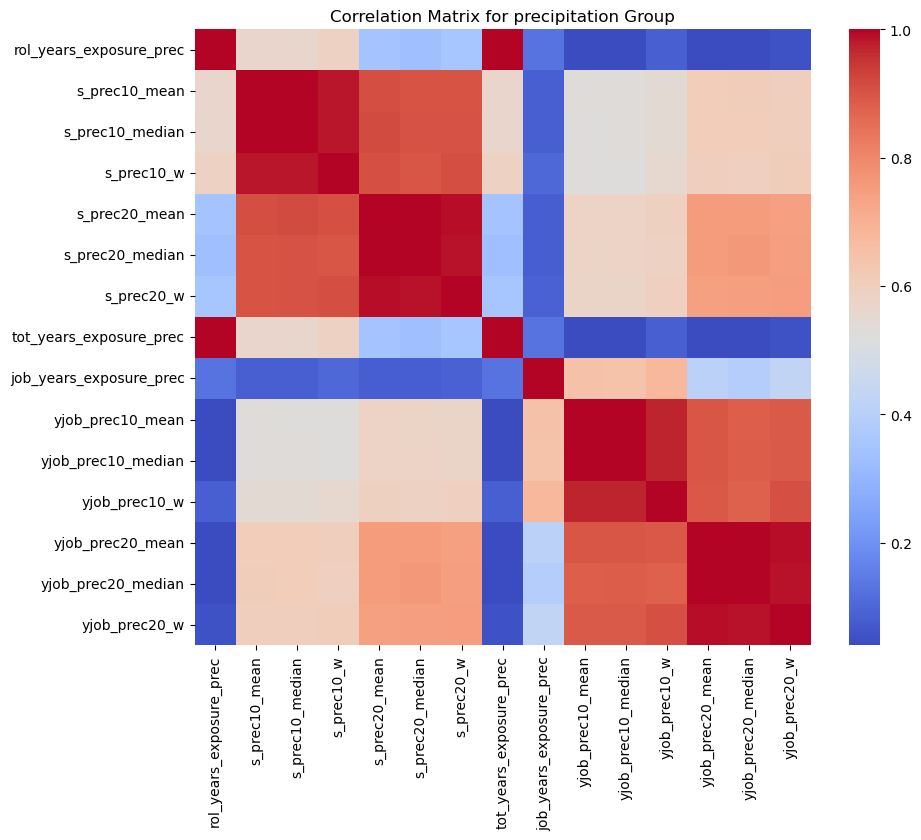

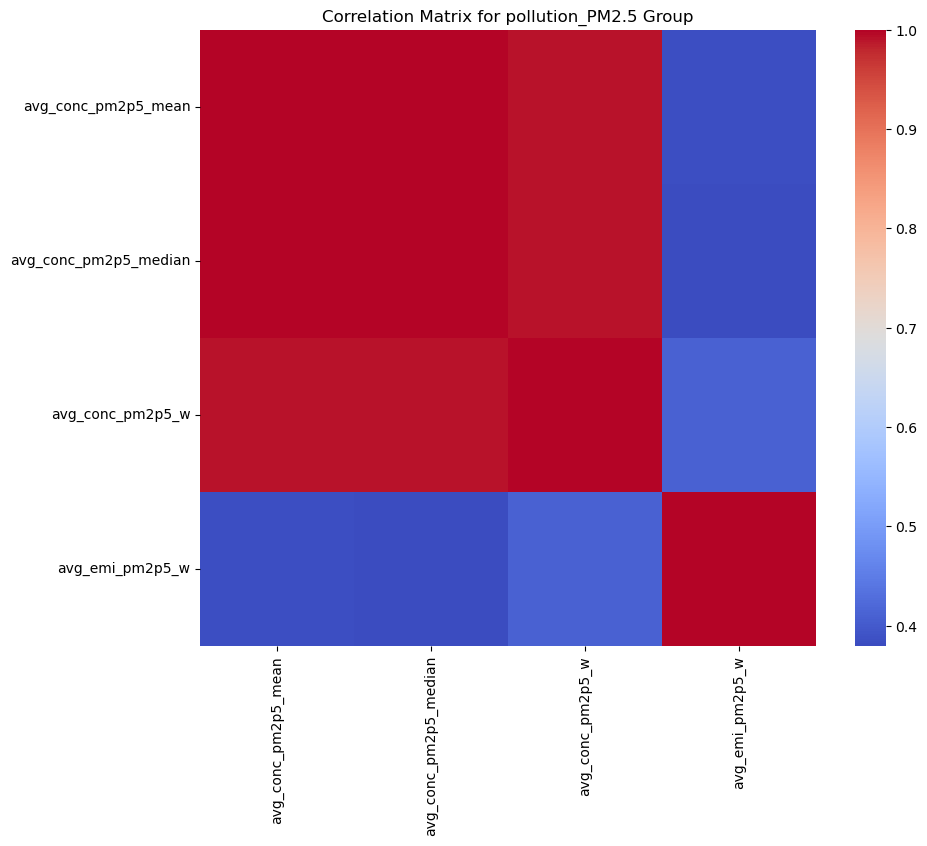

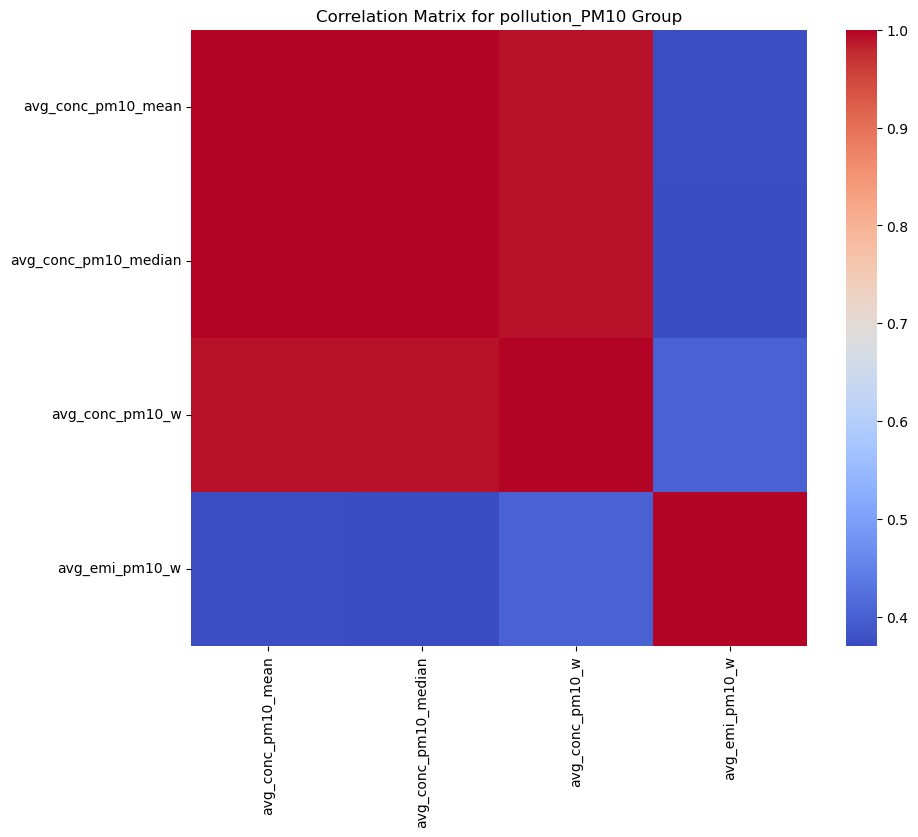

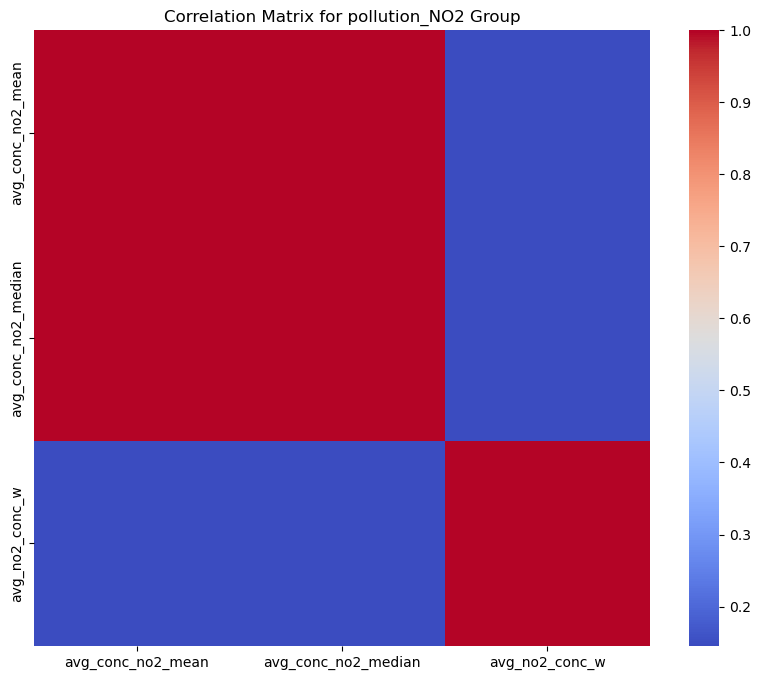

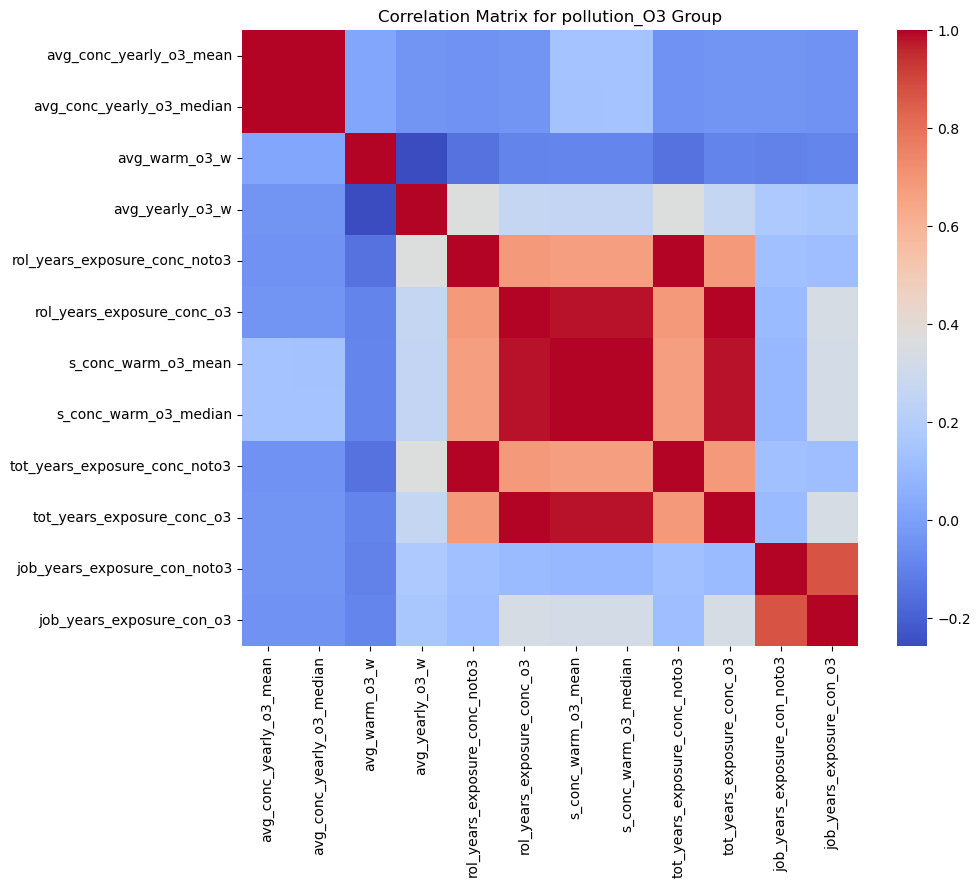

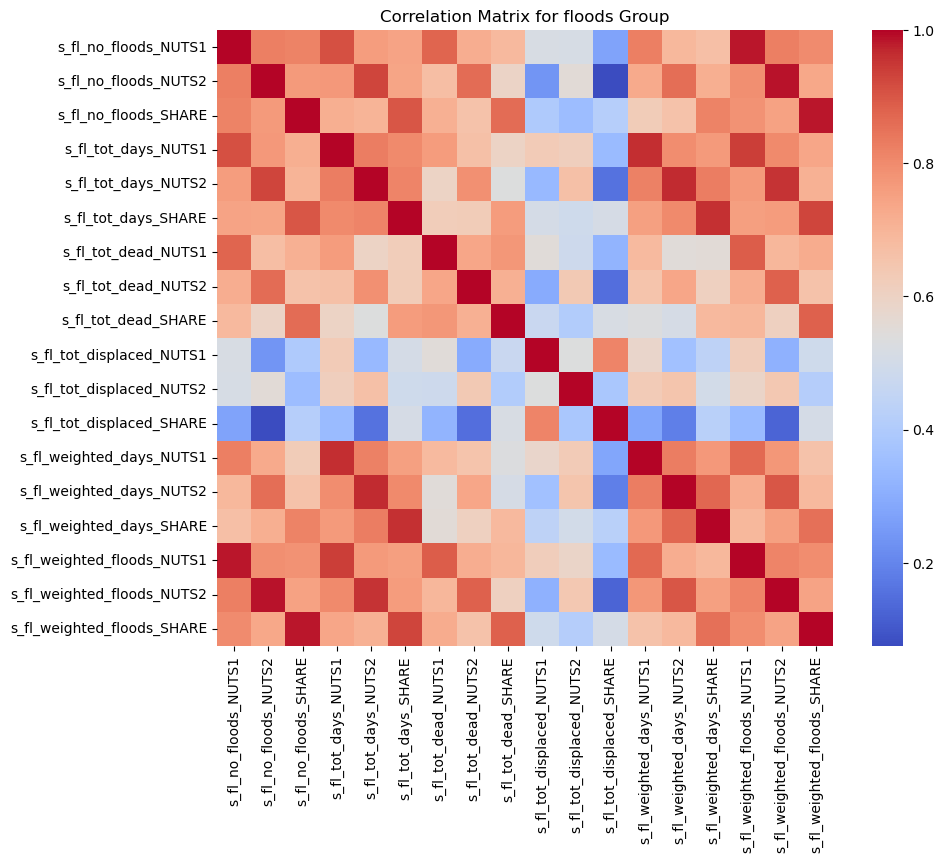

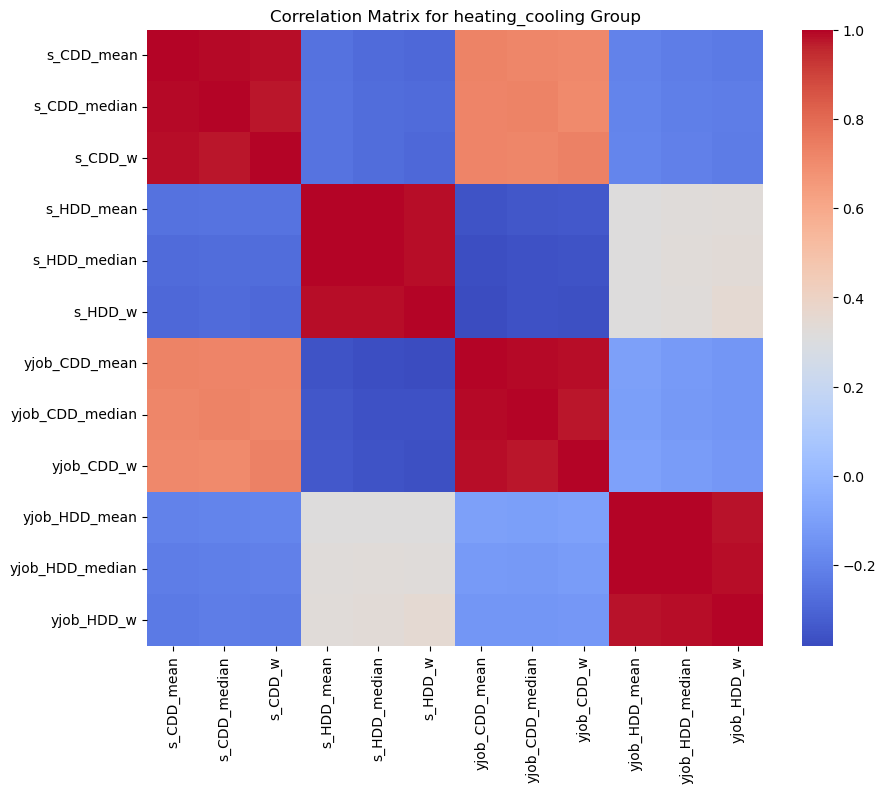

In [9]:
for group_name, features in feature_groups.items():
    # Filter the DataFrame to keep only the current group's features
    df_group = X[features]
    
    # Calculate the correlation matrix
    corr_matrix = df_group.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title(f'Correlation Matrix for {group_name} Group')
    plt.show()

Split the data

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Imputing categorical with most frequent and doing one hot encoding:

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)

# Dictionary to store the top three most important features by group
best_features = {}

# Iterate over each feature group to identify the top three important features
for group_name, features in feature_groups.items():
    # Ensure the feature group is not empty and contains valid features
    if not features:
        continue
    
    # Select the current group's features from the scaled training data
    valid_features = X_train.columns.intersection(features)

    if valid_features.empty:
        print(f"{group_name}: No valid features after data preparation.")
        continue

    # Train the Random Forest model on the selected features
    rf_model.fit(X_train[valid_features], y_train)

    # Get the feature importances and find the three most important ones
    importances = rf_model.feature_importances_
    top_three_indices = np.argsort(importances)[-3:]  # Get indices of the top three features
    top_three_features = valid_features[top_three_indices]
    best_features[group_name] = top_three_features

    # Evaluate the model's performance on the test data
    predictions = rf_model.predict(X_test[valid_features])
    accuracy = accuracy_score(y_test, predictions)
    print(f"{group_name} - Top 3 Important Features: {top_three_features.tolist()}, Accuracy: {accuracy:.4f}")

# Output the best features from each group
print("Best Features by Group:", best_features)


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


temperature - Top 3 Important Features: ['s_tg_neg2p5_0_w', 's_tx_25_27p5_mean', 's_tx_25_27p5_w'], Accuracy: 0.8713


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


radiation - Top 3 Important Features: ['avgjob_radiation_fall_mean', 'avgjob_radiation_winter_median', 'avgjob_radiation_spring_w'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


precipitation - Top 3 Important Features: ['s_prec20_w', 'tot_years_exposure_prec', 'rol_years_exposure_prec'], Accuracy: 0.8717
pollution_PM2.5 - Top 3 Important Features: ['avg_emi_pm2p5_w', 'avg_conc_pm2p5_mean', 'avg_conc_pm2p5_w'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_PM10 - Top 3 Important Features: ['avg_emi_pm10_w', 'avg_conc_pm10_median', 'avg_conc_pm10_w'], Accuracy: 0.8717
pollution_NO2 - Top 3 Important Features: ['avg_no2_conc_w', 'avg_conc_no2_mean', 'avg_conc_no2_median'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_O3 - Top 3 Important Features: ['rol_years_exposure_conc_noto3', 'job_years_exposure_con_noto3', 'job_years_exposure_con_o3'], Accuracy: 0.8717
floods - Top 3 Important Features: ['s_fl_tot_dead_NUTS1', 's_fl_tot_displaced_SHARE', 's_fl_weighted_days_SHARE'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


heating_cooling - Top 3 Important Features: ['s_CDD_mean', 's_HDD_w', 's_HDD_median'], Accuracy: 0.8716
Best Features by Group: {'temperature': Index(['s_tg_neg2p5_0_w', 's_tx_25_27p5_mean', 's_tx_25_27p5_w'], dtype='object'), 'radiation': Index(['avgjob_radiation_fall_mean', 'avgjob_radiation_winter_median',
       'avgjob_radiation_spring_w'],
      dtype='object'), 'precipitation': Index(['s_prec20_w', 'tot_years_exposure_prec', 'rol_years_exposure_prec'], dtype='object'), 'pollution_PM2.5': Index(['avg_emi_pm2p5_w', 'avg_conc_pm2p5_mean', 'avg_conc_pm2p5_w'], dtype='object'), 'pollution_PM10': Index(['avg_emi_pm10_w', 'avg_conc_pm10_median', 'avg_conc_pm10_w'], dtype='object'), 'pollution_NO2': Index(['avg_no2_conc_w', 'avg_conc_no2_mean', 'avg_conc_no2_median'], dtype='object'), 'pollution_O3': Index(['rol_years_exposure_conc_noto3', 'job_years_exposure_con_noto3',
       'job_years_exposure_con_o3'],
      dtype='object'), 'floods': Index(['s_fl_tot_dead_NUTS1', 's_fl_tot_displac

In [12]:
# Step 1: Flatten the list of best features and convert to a set for faster lookup
best_features_set = set(feature for feature_list in best_features.values() for feature in feature_list)

# Step 2: Initialize a list to hold variables to drop
vars_to_drop = []

# Step 3: Identify variables to drop from each feature group
for group_name, features in feature_groups.items():
    vars_to_drop.extend([var for var in features if var not in best_features_set])

# Step 4: Drop these unwanted variables from the scaled DataFrames
X_train_selected = X_train.drop(columns=vars_to_drop, errors='ignore')
X_test_selected = X_test.drop(columns=vars_to_drop, errors='ignore')

# Step 5: Output the shape of original and modified DataFrames to check consistency
print("Original X_train shape:", X_train.shape)
print("Modified X_train shape:", X_train_selected.shape)
print("Original X_test shape:", X_test.shape)
print("Modified X_test shape:", X_test_selected.shape)


Original X_train shape: (61457, 495)
Modified X_train shape: (61457, 352)
Original X_test shape: (15365, 495)
Modified X_test shape: (15365, 352)


In [13]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=100000)

# Train the model on the selected features
log_reg_model.fit(X_train_selected, y_train)

# Make predictions on the test data
predictions = log_reg_model.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Model Accuracy: 0.9028


In [31]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

model = LogisticRegression()
param_grid = {
    'C': [0.1],
    'penalty': ['l2', 'elasticnet'],  # l2 seems to have better accuracy
    'max_iter': [100000],
    'solver': ['lbfgs', 'saga'],  # Include 'saga' solver
    'l1_ratio': [0.1, 0.5, 1]  # l1_ratio is needed for elasticnet
}
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
y_pred = grid_search.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/pytho

Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best score: 0.9045837221645622
Logistic Regression Model Accuracy: 0.9028


In [32]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     13393
           1       0.69      0.44      0.54      1972

    accuracy                           0.90     15365
   macro avg       0.81      0.71      0.74     15365
weighted avg       0.89      0.90      0.89     15365



ROC-AUC Score: 0.9077


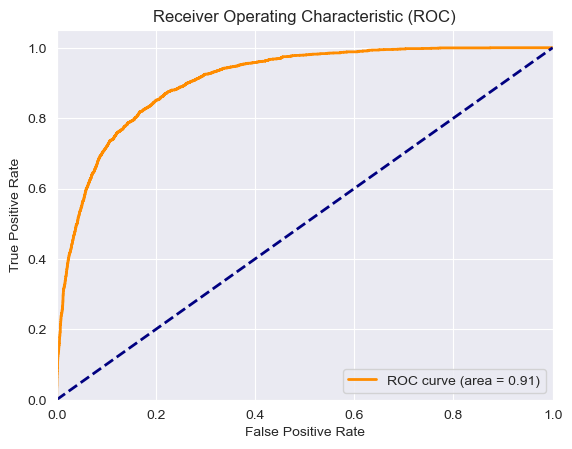

In [33]:
y_pred_proba = grid_search.predict_proba(X_test_selected)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Initialize a new RandomForestClassifier
rf_top_grouped = RandomForestClassifier(random_state=42)

# Fit the RandomForest model on the selected and scaled training data
rf_top_grouped.fit(X_train, y_train)

# Get the parameters of the fitted RandomForestClassifier instance
rf_grouped_parameters = rf_top_grouped.get_params()

# Display each parameter and its value
print("Parameters of the RandomForestClassifier:")
for param, value in rf_grouped_parameters.items():
    print(f"The parameter '{param}' is set to {value}.")

/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Parameters of the RandomForestClassifier:
The parameter 'bootstrap' is set to True.
The parameter 'ccp_alpha' is set to 0.0.
The parameter 'class_weight' is set to None.
The parameter 'criterion' is set to gini.
The parameter 'max_depth' is set to None.
The parameter 'max_features' is set to sqrt.
The parameter 'max_leaf_nodes' is set to None.
The parameter 'max_samples' is set to None.
The parameter 'min_impurity_decrease' is set to 0.0.
The parameter 'min_samples_leaf' is set to 1.
The parameter 'min_samples_split' is set to 2.
The parameter 'min_weight_fraction_leaf' is set to 0.0.
The parameter 'monotonic_cst' is set to None.
The parameter 'n_estimators' is set to 100.
The parameter 'n_jobs' is set to None.
The parameter 'oob_score' is set to False.
The parameter 'random_state' is set to 42.
The parameter 'verbose' is set to 0.
The parameter 'warm_start' is set to False.


In [ ]:
# Ensure necessary imports are included
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV

# Apply the same preprocessing steps to the test set
X_train_selected = X_train[X_train_selected.columns]
X_test_selected = X_test[X_train_selected.columns]

# Initialize a new RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],  # Simplified for speed
    'max_depth': [None, 5, 10, 20],   # Reduced options
    'min_samples_split': [2, 4, 8]  # Default and one variation
}

# Perform grid search with cross-validation
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

try:
    cv_rf.fit(X_train_selected, y_train)
except Exception as e:
    print("Error during GridSearchCV fitting:", e)

try:
    y_pred_proba = cv_rf.predict_proba(X_test_selected)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculate AUC score
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("Error during prediction:", e)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column